In [75]:
%matplotlib inline

#Imports. If you dont have something, pip3 install it on mac, or do something else on windows.
from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import shapely
from adjustText import adjust_text

In [172]:
#Gets datetime for given year and quarter
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")
    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)

#Returns url with the internet data given a year and quarter.
#No idea what the service type parameter is. If you are curious, look up the documentation yourself.
def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)
    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url

In [185]:
#Gets data. Change the year and/or quarter for up to date data
#Will take a while. Leave it running and get yourself some ice cream.
tiles = gp.read_file(get_tile_url("fixed", 2022, 3))

In [405]:
tiles

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,0022131321002111,75,97,959,1,1,"POLYGON ((-158.51624 71.73266, -158.51074 71.7..."
1,0022133222312322,15909,11930,96,17,3,"POLYGON ((-160.02686 70.64359, -160.02136 70.6..."
2,0022133222330032,1773,31968,33,1,1,"POLYGON ((-160.03784 70.63631, -160.03235 70.6..."
3,0022133222330033,10709,4902,91,1,1,"POLYGON ((-160.03235 70.63631, -160.02686 70.6..."
4,0022133222330100,13948,15680,98,23,4,"POLYGON ((-160.02686 70.64177, -160.02136 70.6..."
...,...,...,...,...,...,...,...
6609471,3131120221103110,5135,9456,18,7,1,"POLYGON ((169.35425 -46.58907, 169.35974 -46.5..."
6609472,3131120221111310,32032,45930,54,1,1,"POLYGON ((169.44214 -46.57397, 169.44763 -46.5..."
6609473,3131120300000113,8511,4472,22,4,2,"POLYGON ((170.19470 -46.07704, 170.20020 -46.0..."
6609474,3313201233311012,88120,22133,24,2,1,"POLYGON ((161.68579 -77.42902, 161.69128 -77.4..."


In [251]:
#Shapefile for the US
county_url = "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip" 
counties = gp.read_file(county_url)

In [347]:
il_counties = counties.loc[counties['STATEFP'] == '17'].to_crs(4326) 

In [363]:
#Will take a while.
tiles_in_il_counties = gp.sjoin(tiles, il_counties, how="inner", op='intersects')

/Users/grey/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(-91.74092219531249, -86.79512608593751, 36.69338527922357, 42.78546513630503)

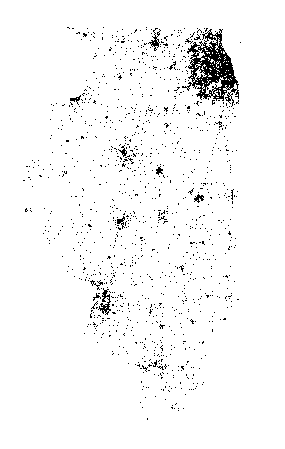

In [404]:
fig, ax = plt.subplots(1, figsize=(20, 8))
il_counties.plot(ax=ax,color='white')
tiles_in_il_counties.plot(ax=ax,color='black')
ax.axis("off")

array([[<AxesSubplot:title={'center':'avg_d_kbps_wt'}>,
        <AxesSubplot:title={'center':'avg_u_kbps_wt'}>]], dtype=object)

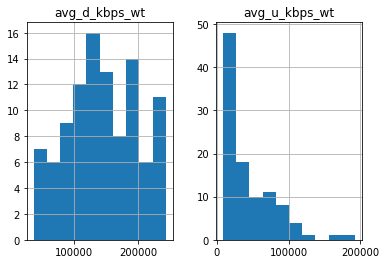

In [412]:
#This will average the download and upload speeds for each county (weighted by the number of tests)
county_stats = (
    tiles_in_il_counties.groupby(["GEOID", "NAMELSAD"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_kbps_wt": np.average(x["avg_d_kbps"], weights=x["tests"]),"avg_u_kbps_wt": np.average(x["avg_u_kbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_il_counties.groupby(["GEOID", "NAMELSAD"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["GEOID", "NAMELSAD"],
    )
)
#Plotted histograms to get an idea of distribution (and where to create bins in plots)
county_stats[['avg_d_kbps_wt','avg_u_kbps_wt']].hist()

In [407]:
county_stats

,GEOID,NAMELSAD,avg_d_kbps_wt,avg_u_kbps_wt,tests
0,17001,Adams County,154212.286299,16430.085890,489
1,17003,Alexander County,37243.253165,8028.544304,79
2,17005,Bond County,78967.966061,18215.117576,825
3,17007,Boone County,198227.144164,22209.519558,3170
4,17009,Brown County,37873.358491,17480.273585,106
...,...,...,...,...,...
97,17195,Whiteside County,185820.932169,78233.893989,2462
98,17197,Will County,234805.716879,44918.275164,38457
99,17199,Williamson County,149978.974578,78514.709782,4917
100,17201,Winnebago County,203970.743862,18844.125779,10916


'\nil_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_17_place.zip")\nil_places = il_places.loc[il_places[\'PCICBSA\'] >= "Y"].sample(15, random_state=1).to_crs(26916)\nil_places["centroid"] = il_places["geometry"].centroid\nil_places.set_geometry("centroid", inplace = True)\ntexts = []\nfor x, y, label in zip(il_places.geometry.x, il_places.geometry.y, il_places["NAME"]):\n    texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))\n\nadjust_text(\n    texts,\n    force_points=0.3,\n    force_text=0.8,\n    expand_points=(1, 1),\n    expand_text=(1, 1),\n    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),\n)\n'

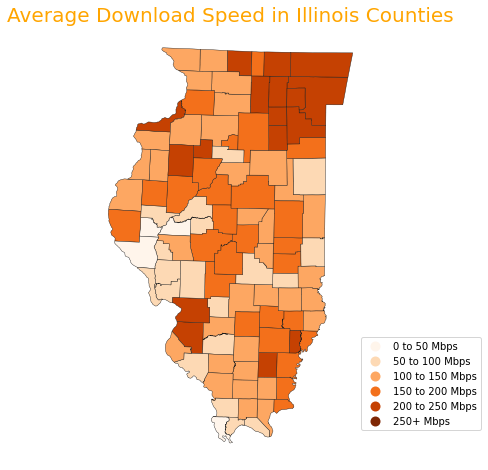

In [421]:
county_data = il_counties[['GEOID', 'geometry']].merge(county_stats, on='GEOID').to_crs(26916)

#Note: you may need to change the labels if the distribution is different from this year.
#labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 75 Mbps", "75 to 100 Mbps", "100 to 125 Mbps", '125 to 150 Mbps', "150 to 175 Mbps", '175 to 200 Mbps', "200 to 225 Mbps", '225 to 250 Mbps','250+']
labels = ["0 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps", "200 to 250 Mbps", '250+ Mbps']

county_data['group'] = pd.cut(
    county_data.avg_d_kbps_wt, 
    #Change these values to change the cutoffs of each bin. Make sure to change the labels as well.
    #(0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000, 1000000000),
    (0, 50000, 100000, 150000, 200000, 250000, 1000000000),
    right=False, 
    labels = labels
)

fig, ax = plt.subplots(1, figsize=(20, 8))
county_data.plot(column="group", cmap="Oranges", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True)

ax.axis("off")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.45, 0.3))
plt.title("Average Download Speed in Illinois Counties",fontsize=20,color='orange')

#If we want labels
'''
il_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_17_place.zip")
il_places = il_places.loc[il_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
il_places["centroid"] = il_places["geometry"].centroid
il_places.set_geometry("centroid", inplace = True)
texts = []
for x, y, label in zip(il_places.geometry.x, il_places.geometry.y, il_places["NAME"]):
    texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

adjust_text(
    texts,
    force_points=0.3,
    force_text=0.8,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)
'''

Text(0.5, 1.0, 'Average Upload Speed in Illinois Counties')

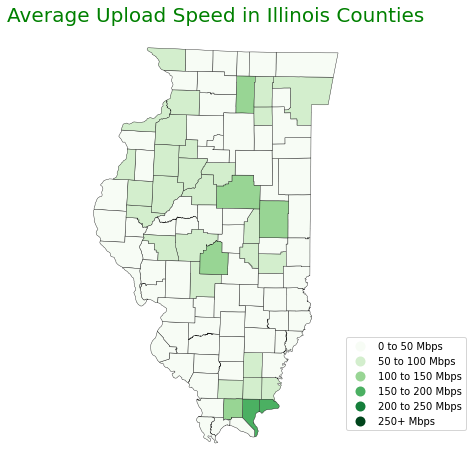

In [422]:
labels2 = ["0 to 10 Mbps", "10 to 20 Mbps", "20 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150+ Mbps"]

county_data['group2'] = pd.cut(
    county_data.avg_u_kbps_wt, 
    #(0, 10000, 20000, 50000, 100000, 150000, 500000000), 
    (0, 50000, 100000, 150000, 200000, 250000, 1000000000),
    right=False, 
    labels = labels
)

fig, ax = plt.subplots(1, figsize=(20, 8))

county_data.plot(column="group2", cmap="Greens", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.45, 0.3))
plt.title("Average Upload Speed in Illinois Counties",fontsize=20,color='green')

/Users/grey/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/jc/6wyz3_ld0137ldxkzfbsq13w0000gn/T/ipykernel_19584/389878519.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...
Right CRS: EPSG:4326

  district_data = gp.sjoin(cook, data[['avg_d_kbps','avg_u_kbps','tests','geometry']], how="inner", op='intersects')


array([[<AxesSubplot:title={'center':'avg_d_kbps_wt'}>,
        <AxesSubplot:title={'center':'avg_u_kbps_wt'}>]], dtype=object)

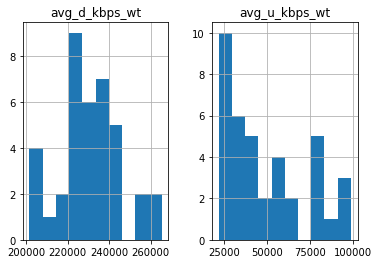

In [318]:
#We want to get a file from a RESTful API so we do not have to store it after the progrma runs,
#but I have not found one, so for now I just downloaded something off the web
#This shapefile is for cook county only
cook = gp.read_file('cook.zip')
data = (tiles_in_il_counties[tiles_in_il_counties['NAMELSAD'] == 'Cook County'])

#Gather the data into sub-county level (district? or something else? I will use district)
district_data = gp.sjoin(cook, data[['avg_d_kbps','avg_u_kbps','tests','geometry']], how="inner", op='intersects')
district_data = (district_data.groupby('name').apply(lambda x: pd.Series({"avg_d_kbps_wt": np.average(x["avg_d_kbps"], weights=x["tests"]),"avg_u_kbps_wt": np.average(x["avg_u_kbps"], weights=x["tests"])})))
district_data = district_data.merge(cook,on='name')

#Plot histogram for distribution
district_data[['avg_d_kbps_wt','avg_u_kbps_wt']].hist()

/Users/grey/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:939: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fec052568e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(patches, categories, **legend_kwds)


Text(0.5, 1.0, 'Average Upload Speed in Cook County, Illinois')

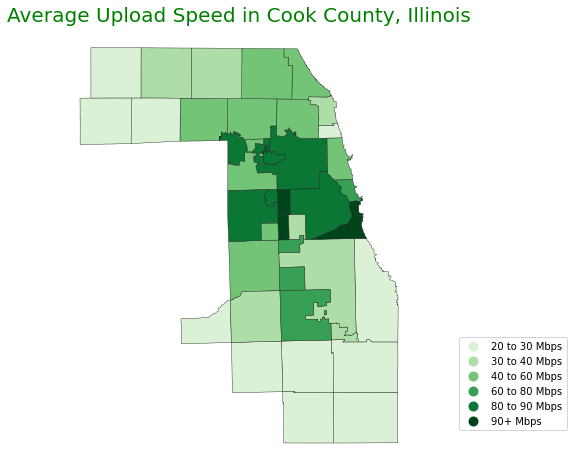

In [424]:
labels3 = ['_nolegend_', "20 to 30 Mbps", "30 to 40 Mbps", "40 to 60 Mbps", "60 to 80 Mbps","80 to 90 Mbps","90+ Mbps"]
#"20 to 25 Mbps",
district_data['group3'] = pd.cut(
    district_data.avg_u_kbps_wt, 
    (0, 20000, 30000, 40000, 60000, 80000, 90000, 1000000), 
    right=False, 
    labels = labels3
)

fig, ax = plt.subplots(1, figsize=(20, 8))
gp.GeoDataFrame(district_data['group3'], geometry=district_data['geometry']).plot(column="group3", cmap="Greens", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True)
ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.45, 0.3))
#leg.set_title("Mean upload speed (Mbps)\nin Cook County, Illinois")
plt.title("Average Upload Speed in Cook County, Illinois",fontsize=20,color='green')

/Users/grey/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:939: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fee15ba2550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(patches, categories, **legend_kwds)


Text(0.5, 1.0, 'Average Download Speed in Cook County, Illinois')

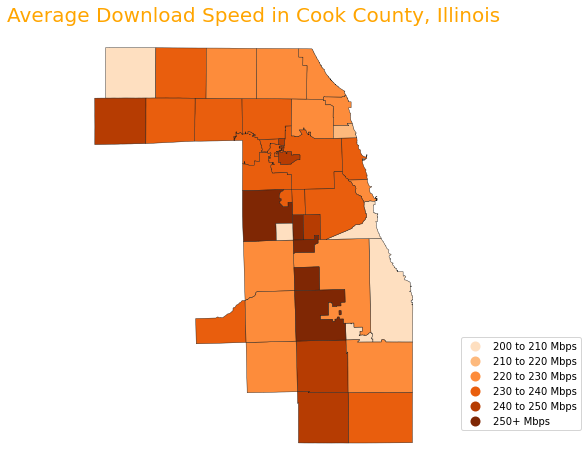

In [423]:
labels4 = ["_nolegend_", "200 to 210 Mbps", "210 to 220 Mbps", "220 to 230 Mbps", "230 to 240 Mbps", "240 to 250 Mbps","250+ Mbps"]

district_data['group4'] = pd.cut(
    district_data.avg_d_kbps_wt, 
    (0, 200000, 210000, 220000, 230000, 240000, 250000, 1000000), 
    right=False, 
    labels = labels4
)

fig, ax = plt.subplots(1, figsize=(20, 8))
gp.GeoDataFrame(district_data['group4'], geometry=district_data['geometry']).plot(column="group4", cmap="Oranges", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True)
ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.45, 0.3))
plt.title("Average Download Speed in Cook County, Illinois",fontsize=20,color='orange')